# Genetic Algorithms for Region Paritioning

We will be using some Python modules installed by pip rather than Anaconda, so I must adjust the import path.

In [1]:
import sys
sys.path.insert( 1, '/usr/local/lib/python3.7/site-packages' )

---

## Import the data

In [25]:
import pandas
data_filename = 'wrestling-schools-data.csv'
data_table = pandas.read_csv( data_filename )
len( data_table )

106

### Preview it

In [26]:
data_table[:5]

,UniqueID,College/University Name,Street,City,State,Latitude,Longitude,Power-1,Power-2,NCAA Asgt,ND Asgt,ND Asgt2,ND Asgt3
0,1,Adrian College,10 S Madison St,Adrian,MI,41.899337,-84.044547,2.4514,2.927,3,2.0,1.0,5.0
1,2,Alfred State College (add 2018),10 Upper College Drive,Alfred,NY,42.254334,-77.789646,0.0000,0.000,0,NaN,NaN,NaN
2,3,Alma College,614 W Superior St,Alma,MI,43.380011,-84.655654,5.1091,5.941,3,6.0,1.0,5.0
3,4,Augsburg,2211 Riverside Ave,Minneapolis,MN,44.963541,-93.267835,9.6340,8.890,2,6.0,5.0,3.0
4,5,Augustana (IL),639 38th St,Rock Island,IL,41.470591,-90.583733,0.0000,0.301,1,2.0,4.0,3.0


### Drop schools we don't want in this analysis

Some schools were dropped for various domain-specific reasons.  See paper.

In [4]:
data_table = pandas.concat( [ data_table[:31], data_table[32:61], data_table[62:85], data_table[86:] ] )
num_schools = len( data_table )
num_schools

103

### Make it easy to fetch desired rows/columns

In [5]:
def school ( key ):
    column = 'UniqueID' if type( key ) == int else 'College/University Name'
    return data_table[data_table[column] == key].iloc[0]
( SCH_ID, SCH_NAME, SCH_ADDR, SCH_CITY, SCH_STATE, SCH_LAT, SCH_LNG, SCH_POW1, SCH_POW2,
  SCH_NCAA, SCH_ND1, SCH_ND2, SCH_ND3 ) = list( data_table.columns.values )
def all_ids ():
    return list( data_table['UniqueID'] )
def index_to_id ( index ):
    return all_ids()[index]
# print( school( 2 )[SCH_NAME] )
# print( school( 'Augsburg' )[SCH_ID] )
# print( school( 50 )[SCH_LAT], get_school( 50 )[SCH_LNG] )

---

## Map distance tools

Import tools that can compute distance on the (curved) surface of the earth.

In [6]:
from geopy.distance import great_circle
def school_latlng ( school ):
    return ( school[SCH_LAT], school[SCH_LNG] )

Now pre-compute the distance between any two pair of schools and cache it in a matrix, because we'll be asking these distance questions a million times below, and this cache will speed it up a lot.

In [7]:
school_locations = [ school_latlng( school( index_to_id( i ) ) )
                     for i in range( num_schools ) ]
distance_matrix = [ [ great_circle( school_locations[i], school_locations[j] ).miles
                      for i in range( num_schools ) ] for j in range( num_schools ) ]
def distance_lookup ( school_index1, school_index2 ):
    return distance_matrix[school_index1][school_index2]

---

## Utilities for partitions

In [8]:
num_parts_in_partition = 6
def indices_for_part_in_partition ( part_index, partition ):
    return [ i for i in range( len( partition ) ) if partition[i] == part_index ]
def schools_in_part_in_partition ( part_index, partition ):
    return [ school( index_to_id( i ) )
             for i in indices_for_part_in_partition( part_index, partition ) ]
def size_of_part_in_partition ( part_index, partition ):
    return len( indices_for_part_in_partition( part_index, partition ) )
def random_partition ():
    import random
    return [ random.randint( 0, num_parts_in_partition ) for i in range( num_schools ) ]

In [9]:
import statistics
def print_partition ( partition ):
    for part_index in range( num_parts_in_partition ):
        schools = schools_in_part_in_partition( part_index, partition )
        powers = [ school[SCH_POW2] for school in schools ]
        print( 'Region {:1d}, {:2d} schools, mean power {:7.5f} (stdev {:7.5f}):'.format(
            part_index + 1, size_of_part_in_partition( part_index, partition ),
            statistics.mean( powers ), statistics.stdev( powers ) ) )
        print( '---------------------------------------------------------' )
        centroid = (
            statistics.mean( [ school[SCH_LAT] for school in schools ] ),
            statistics.mean( [ school[SCH_LNG] for school in schools ] ),
        )
        print( '    Centroid: {:7.3f} lat, {:7.3f} lon'.format(
            centroid[0], centroid[1] ) )
        latlngs = [ school_latlng( school ) for school in schools ]
        print( '    Mean distance to centroid: {:8.3f} miles'.format(
            statistics.mean( [ great_circle( centroid, latlng ).miles for latlng in latlngs ] )
        ) )
        for s in schools:
            print( '        {:30.30s} {:30.30s} {:>7.1f} miles'.format(
                s[SCH_NAME],
                '{}, {}, {}'.format( s[SCH_ADDR], s[SCH_CITY], s[SCH_STATE] ),
                great_circle( school_latlng( s ), centroid ).miles
            ) )
        print()
# print_partition( random_partition() )

---

## Import map-drawing tools

In [10]:
from plotly_for_usa_points import usa_map # this works only if you've done conda install plotly
# also one needs all the extensions mentioned here:
# https://github.com/plotly/plotly.py#jupyterlab-support-python-35

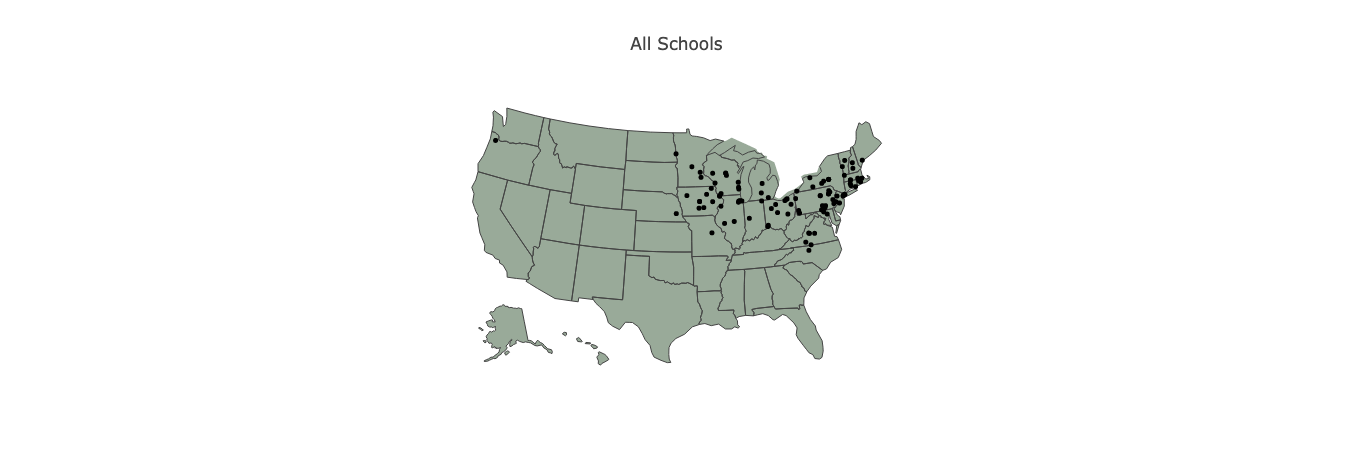

In [11]:
usa_map( { 'black' : [ school_latlng( school( id ) ) for id in all_ids() ] }, 'All Schools' )

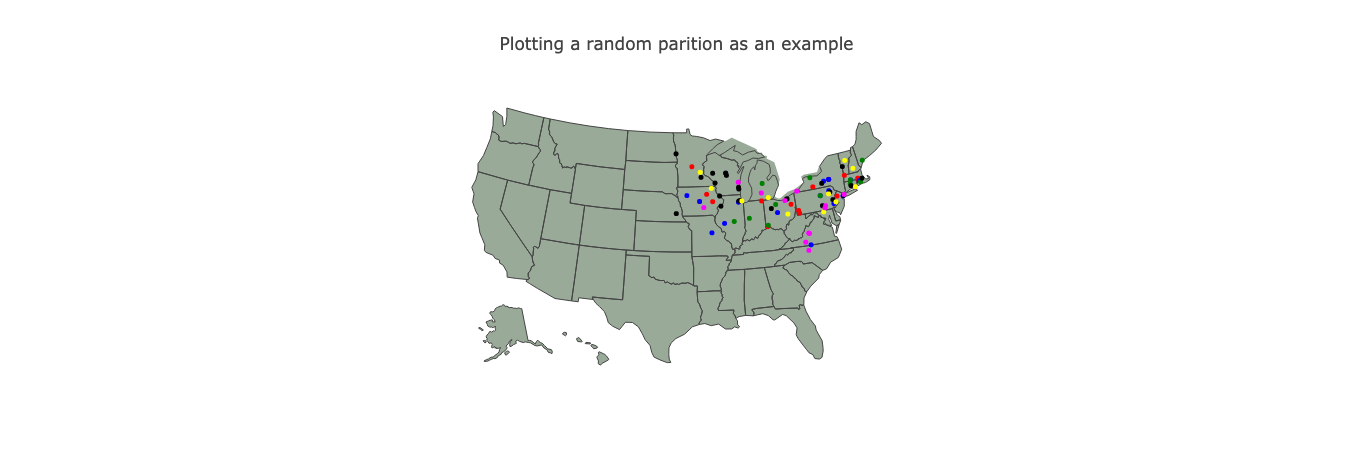

In [12]:
def partition_map ( schools_partition, title = 'Partition of All Schools' ):
    colors = [ 'red', 'blue', 'green', 'black', 'yellow', 'magenta', 'cyan', 'white', 'gray', 'orange' ]
    def points_in_part ( part_index ):
        return [ school_latlng( s )
                 for s in schools_in_part_in_partition( part_index, schools_partition ) ]
    return usa_map( {
        colors[i] : points_in_part( i ) for i in range( max( schools_partition ) )
    }, title )
partition_map( random_partition(), 'Plotting a random parition as an example' )

---

## Components of the Objective Function

First, we will want to experiment with the range of the various components of the objective function, to see how we should rescale them to match each other.

In [13]:
def range_experiment ( func, num_tries=100 ):
    data = [ func( random_partition() ) for i in range( num_tries ) ]
    return min( data ), max( data )

### Component 1: Variance of size of parts in the partition

In [14]:
def part_size_variance ( partition ):
    return statistics.variance( [
        size_of_part_in_partition( part, partition )
        for part in range( num_parts_in_partition )
    ] )
# print( range_experiment( part_size_variance ) ) # gives a max in the 50s
# plus we want size variance to be bad, so we need a -1 multiplier, so:
def obj_fn_component_1 ( partition ):
    return part_size_variance( partition ) * -1.0 / 50

### Component 2: Total distance between schools in each part of the partition

In [15]:
def total_distance_in_one_part ( part_index, partition ):
    indices = indices_for_part_in_partition( part_index, partition )
    return sum( [ distance_lookup( i, j )
                  for i in indices for j in indices if i < j ] )
def total_distance_of_all_parts ( partition ):
    return sum( [ total_distance_in_one_part( index, partition )
                  for index in range( num_parts_in_partition ) ] )
# print( range_experiment( total_distance_of_all_parts ) )
# plus we want travel distance to be bad, so we need a -1 multiplier, so:
def obj_fn_component_2 ( partition ):
    return total_distance_of_all_parts( partition ) * -1.0 / 50000

### Component 3: Variance of mean powers of each part in partition 

In [16]:
def mean_power_of_part ( part_index, partition ):
    powers = [ s[SCH_POW2] for s in schools_in_part_in_partition( part_index, partition ) ]
    if len( powers ) > 0:
        return statistics.mean( powers )
    else:
        return 0
def part_power_variance ( partition ):
    return statistics.variance( [
        mean_power_of_part( part, partition )
        for part in range( num_parts_in_partition )
    ] )
# print( range_experiment( part_power_variance ) )
# plus we want power variance to be bad, so we need a -1 multiplier, so:
def obj_fn_component_3 ( partition ):
    return part_power_variance( partition ) * -1.0 / 5

### Objective function: sum of 3 components

In [17]:
def objective_function ( partition ):
    return obj_fn_component_1( partition ) \
         + obj_fn_component_2( partition ) \
         + obj_fn_component_3( partition )

---

## Solving the problem

In [18]:
num_generations = 10000
def progress_bar ( name="Progress", size=num_generations ):
    from tqdm import tqdm_notebook
    bar = tqdm_notebook( range( size ), desc=name )
    def step ( *args ):
        bar.update( 1 )
        bar.display()
    return step
from ga_for_partitions import optimize_partition
best, fitness_curve = optimize_partition(
    objective_function = objective_function,
    initial_pool = [ random_partition() for i in range( num_parts_in_partition ) ],
    size_of_partition = num_parts_in_partition,
    prob_mutate = 0.1,
    num_generations = num_generations,
    progress_callback = progress_bar()
)

After 10000 generations: max score =  -1.6606   100% done, 15:56/15:56 (00:00)


In [22]:
print_partition( best )

Region 1, 13 schools, mean power 2.65169 (stdev 4.79868):
---------------------------------------------------------
    Centroid:  39.249 lat, -78.329 lon
    Mean distance to centroid:  137.454 miles
        Alfred State College  (add 201 10 Upper College Drive, Alfred   209.5 miles
        Averett University (add 2017)  420 W Main St, Danville, VA      193.4 miles
        Elizabethtown                  1 Alpha Dr, Elizabethtown, PA    111.2 miles
        Ferrum College                 215 Ferrum Mountain Rd, Ferrum   184.5 miles
        Gettysburg                     300 N Washington St, Gettysbur    70.8 miles
        Greensboro College             815 W Market St, Greensboro, N   233.9 miles
        Johns Hopkins                  400 N. Charles Street, Baltimo    92.0 miles
        McDaniel                       2 College Hill, Westminster, M    74.2 miles
        Messiah                        1 College Ave, Mechanicsburg,     96.7 miles
        Thiel                          Coll

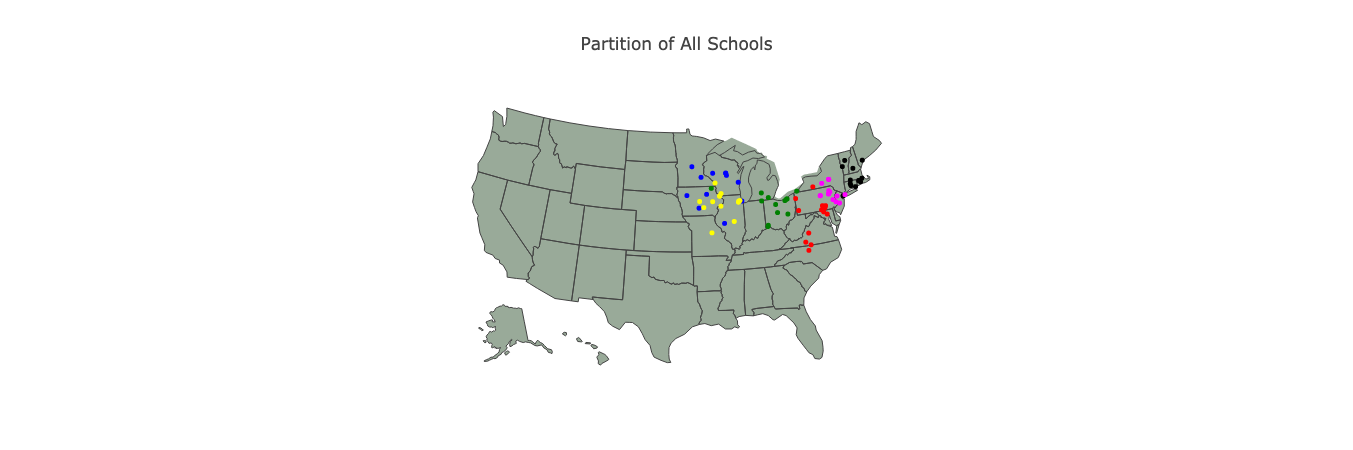

In [23]:
partition_map( best )

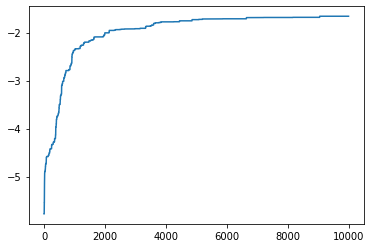

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot( range( len( fitness_curve ) ), fitness_curve )